# Classification Data Preparation
**Hunter Estuary KBA, NSW - Change Detection**


Author: Michael Dear, June 2024

This notebook adds classification variables to the dataset.

## Setup

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Global Parameters
* Global parameters are used in multiple places
* Local parameters should be found above the relevant code

In [2]:
from global_params import *

# Random state for reproducibility
random_state = 11

y_var = ['class_num']

## Step 1: Load data

In [3]:
ds = xr.load_dataset(netcdf_dir+study_area_abbrev+'.nc')

In [4]:
# Replace NaN with -999
ds = ds.where(ds.notnull(), -999)

In [5]:
mask = xr.load_dataarray(netcdf_dir+'mask.nc')

In [6]:
# Load the polygon
poly = gpd.read_file(vector_dir+study_area_abbrev+'.geojson')

# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [7]:
# Select the polygon to use
poly = poly[poly['name']=='Buffered 1000m']
poly

,name,description,timestamp,begin,end,altitudemode,tessellate,extrude,visibility,draworder,icon,snippet,geometry
2,Buffered 1000m,"<html xmlns:fo=""http://www.w3.org/1999/XSL/For...",None,None,None,clampToGround,-1,0,-1,None,None,,MULTIPOLYGON Z (((1814655.723 -3723941.457 0.0...


In [8]:
# Set the crs to 4326, then convert to projected crs
# poly = poly.set_crs(4326).to_crs(crs)
poly = poly.to_crs(crs)

In [9]:
# Put the period names in a list for convenience.
periods = list(ds.period.values)
periods

['Sep 2003', 'Sep 2023']

## Step 2: Classify

### Ground-truth Points (GTP)
The process is:
1. Create polygons for each class using QGIS, Google Earth, and composite plots for each period.
2. Intersect the polygons with the data array to create a candidate set of points for each period.
3. Reduce the candidate set in each class to the size of the smallest class.
4. Train the classifier.
5. Predict.

See https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe for converting a data array to points.

### Select the variables to use for classification

In [14]:
list(ds.data_vars.keys())

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI',
 'Kmeans_Class',
 'RF_Class']

In [15]:
X_vars = list(ds.data_vars.keys())[:9]
X_vars

['nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir',
 'nbart_swir_1',
 'nbart_swir_2',
 'NDVI',
 'NBR',
 'NDWI']

### Function to create a classification variable

In [83]:
def classify(ds, X_vars, y_var, buffer=None, clf_method='RF', svm_kernel='rbf'):
    '''
    Create a classification variable using a given classifier.
    ds: The dataset containing the data variables
    X_vars: The predictor variables for the classification
    y_var: The variable of labelled classes
    buffer: The amount to buffer each gtp polygon; negative values give an internal buffer
    clf_method: RF - random forest; SVM - support vector machine
    svm_kernel: The kernel to use for SVM classifier
    '''
    # Read in the labelled polygons
    gtp_polys = [gpd.read_file(vector_dir+'gtp_polygons_'+str(i)+'.geojson').to_crs(crs) for i in [0,1]]

    # Apply internal buffer to gtp polygons if required
    if buffer:
        for i in [0,1]:
            gtp_polys[i]['geometry'] = gtp_polys[i].buffer(buffer)

    ############################

    # Create the GTP data frames
    gtp_base = [[],[]]

    for i in [0,1]:
        # Convert the data array to a data frame
        df = ds.isel(period=i).to_dataframe().reset_index()
        
        # Convert to a GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y)).set_crs(crs)
        
        # Intersect the points with the polygons
        gdf = gpd.sjoin(gdf, gtp_polys[i], how='inner') # Limit to polygon

        # Drop unwanted columns
        gtp_base[i] = gdf[X_vars+['class_num','class_name','geometry']]

        # Change the class_num variable to integer
        gtp_base[i]['class_num'] = gtp_base[i]['class_num'].astype(np.int16)

    # Reduce each class to the size of the smallest class
    sample_size = np.min([gtp_base[i]['class_num'].value_counts().min() for i in [0,1]])
    gtp_equal = [pd.concat([gtp_base[i][gtp_base[i]['class_num']==cl].sample(sample_size, random_state=random_state) 
                    for cl in gtp_base[i]['class_num'].unique()], axis=0) 
                    for i in [0,1]]

    # Count the number of points in each class
    cl_sizes = [gtp_equal[i]['class_num'].value_counts() for i in [0,1]]
    
    # Count the number of missing values
    nan_sizes = [(gtp_equal[i]==nodata_val).sum() for i in [0,1]]
    # for i in [0,1]:
    #     print('Number of nodata values in each class (should be 0):\n')
    #     print(periods[i])
    #     print('============')
    #     print((gtp_equal[i]==nodata_val).sum())
    #     print('--------------\n')

    ############################

    # Add a nodata class
    # Get the size of the classes
    cl_size = len(gtp_equal[0][gtp_equal[0]['class_num']==1])
   
    # Create an array of -999
    nodata_df = pd.DataFrame([[-999 for i in gtp_equal[0].columns] for j in np.arange(cl_size)], columns=gtp_equal[0].columns)
    nodata_df['class_num'][nodata_df['class_num']==-999] = 0
    nodata_df['class_name'][nodata_df['class_name']==-999] = 'No Data'
 
    # Append to each df in gtp_equal
    gtp_equal = [pd.concat([df, nodata_df]) for df in gtp_equal]


    ############################

    # Create the cl_names list
    # See https://stackoverflow.com/a/52270276/8299958 for joining pandas columns
    cl_num_name = np.char.split(
        (np.unique(gtp_equal[0][['class_num','class_name']]
         .apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
        ).astype(str),
        sep=', '
    )
    cl_names = [cl_num_name[i][1] for i in np.arange(len(cl_num_name))]

    ############################

    # Get the X and y variables data
    X = [gdf[X_vars] for gdf in gtp_equal]
    y = [gdf[y_var] for gdf in gtp_equal]

    # Split the data into training and test sets using stratification
    # Need to use `stratify` to get the same number of samples in each class
    # https://stackoverflow.com/a/29477256/8299958
    gtp_tt = [train_test_split(X[i], y[i], test_size=0.2, stratify=y[i], random_state=random_state) for i in [0,1]]

    # Train-test set sizes
    tt_sizes = pd.DataFrame([[int(len(gtp_tt[i][0])/len(cl_names)),int(len(gtp_tt[i][1])/len(cl_names))] for i in [0,1]],
            columns=['Train', 'Test'],
            index=periods)
    
    ############################
    
    # Train and test the classification
    
    # List to hold the trained classifiers
    clfs = []
    # List to hold the accuracies
    acc = []
    # List to hold the precision and recall data frames
    pre_rec = []
    # List to hold the confusion matrix data frames
    cm = []

    
    for i in [0,1]:
        # Create and fit the RF classifier
        if clf_method == 'RF':
            clf = RandomForestClassifier(random_state=random_state)
        elif clf_method == 'SVM':
            clf = svm.SVC(kernel=svm_kernel, random_state=random_state)
    
        # Fit the classifier to the training data 
        clf.fit(gtp_tt[i][0], gtp_tt[i][2])
    
        # Append model to list
        clfs.append(clf)
        
        # Predict
        y_pred = clf.predict(gtp_tt[i][1])
    
        # Assess accuracy, precision, recall
        acc.append(accuracy_score(gtp_tt[i][3], y_pred))
        pre_rec.append(pd.DataFrame({'Precision': precision_score(gtp_tt[i][3], y_pred, average=None),
                                   'Recall': recall_score(gtp_tt[i][3], y_pred, average=None)
                                  },
                                   index=cl_names)
                      )
    
        # Confusion matrix
        cm.append(pd.DataFrame(confusion_matrix(gtp_tt[i][3], y_pred),
                               columns = cl_names,
                                      index=cl_names
                              )
                 )

    ############################

    # Predictions for whole dataset

    # Re-fit the models to all the available training data
    clfs = [clf.fit(X[i],y[i]) for i, clf in enumerate(clfs)]

    # Arrays to hold the predicted classes
    clf_arrs = [[] for i in [0,1]]

    # Sizes for reshaping flattened arrays
    w = ds.sizes['y']
    l = ds.sizes['x']

    # Perform the predictions
    clf_arrs = [clfs[i].predict(ds.sel(period=periods[i]).to_dataframe()[X_vars].values).reshape(w,l) for i, period in enumerate(periods)]

    # Data array for the classification 
    class_da = xr.DataArray(clf_arrs, coords = ds.coords)
    class_da.name = clf_method+'_Class'
   
    ############################

    # Objects to return
    return {
        'class_sizes':cl_sizes,
        'nan_sizes':nan_sizes,
        'train_test_sizes':tt_sizes,
        'accuracy':acc,
        'precision_recall':pre_rec,
        'conf_mat':cm,
        'classifiers':clfs,
        'class_da':class_da
        
    }
    


In [84]:
classification = classify(ds, X_vars, y_var, clf_method='SVM')

In [85]:
ds['SVM_Class'] = classification['class_da']
ds

<xarray.Dataset>
Dimensions:       (period: 2, y: 496, x: 779)
Coordinates:
  * y             (y) float64 -3.717e+06 -3.717e+06 ... -3.732e+06 -3.732e+06
  * x             (x) float64 1.812e+06 1.812e+06 ... 1.836e+06 1.836e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Sep 2003' 'Sep 2023'
Data variables:
    nbart_red     (period, y, x) float32 752.5 693.5 692.5 ... 176.0 176.5 175.0
    nbart_blue    (period, y, x) float32 397.5 355.5 367.0 ... 387.5 388.5 389.0
    nbart_green   (period, y, x) float32 659.5 624.5 630.5 ... 305.5 304.0 303.0
    nbart_nir     (period, y, x) float32 2.076e+03 2.06e+03 ... 124.5 125.5
    nbart_swir_1  (period, y, x) float32 2.264e+03 1.94e+03 ... 53.0 53.5
    nbart_swir_2  (period, y, x) float32 1.315e+03 1.072e+03 ... 39.5 41.5
    NDVI          (period, y, x) float32 0.4719 0.5012 ... -0.1865 -0.1794
    NBR           (period, y, x) float32 0.2247 0.3167 0.3166 ... 0.5354 0.5104
    NDWI          (period, y, x) float32 -0.5204 -0.5371 ... 0.4309 0.4268
    RF_Class      (period, y, x) int64 5 5 5 5 5 5 6 5 5 5 ... 1 1 1 1 1 1 1 1 1
    SVM_Class     (period, y, x) int64 5 5 5 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1 1

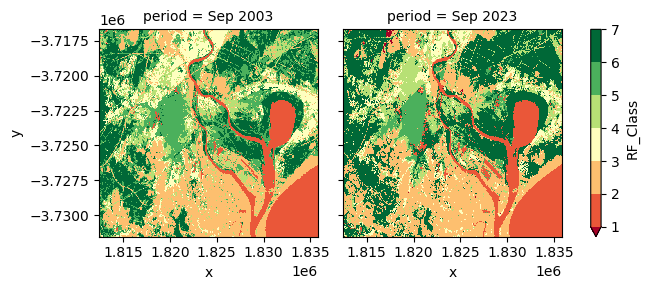

In [86]:
ds['RF_Class'].plot(col='period', 
                 levels=np.unique(ds.RF_Class)+1,
                 cmap='RdYlGn')

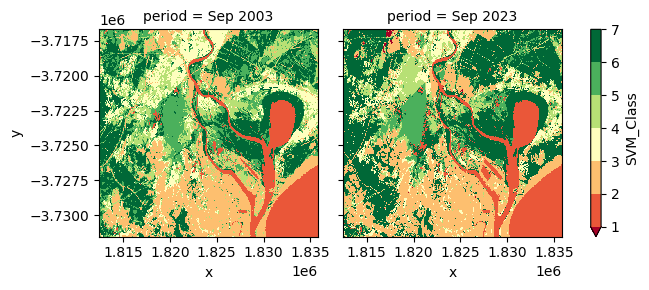

In [87]:
ds['SVM_Class'].plot(col='period', 
                 levels=np.unique(ds.RF_Class)+1,
                 cmap='RdYlGn')

## Step 3: Export data 

### netCDF

In [88]:
# Save as netCDF
ds.to_netcdf(netcdf_dir+study_area_abbrev+'.nc')

### GeoTIFF - Time steps

Each year is saved with all variables in a geoTIFF file.

**Note**: Converting `to_array()` is essential to avoid "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" error.  


In [89]:
for period in ds.period.values:
     (ds
     .sel(period=period)
     .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'.tiff')
     )

In [73]:
# Single variable
class_var = 'RF_Class'
for period in ds.period.values:
     (ds[class_var]
     .sel(period=period)
     # .to_array() # Essential!
     .rio.to_raster(geotiff_dir+study_area_abbrev+'_'+str(period)+'_'+class_var+'.tiff')
     )

---------

In [105]:
ds

<xarray.Dataset>
Dimensions:       (period: 2, y: 496, x: 779)
Coordinates:
  * y             (y) float64 -3.717e+06 -3.717e+06 ... -3.732e+06 -3.732e+06
  * x             (x) float64 1.812e+06 1.812e+06 ... 1.836e+06 1.836e+06
    spatial_ref   int32 3577
  * period        (period) <U8 'Sep 2003' 'Sep 2023'
Data variables:
    nbart_red     (period, y, x) float32 752.5 693.5 692.5 ... 176.0 176.5 175.0
    nbart_blue    (period, y, x) float32 397.5 355.5 367.0 ... 387.5 388.5 389.0
    nbart_green   (period, y, x) float32 659.5 624.5 630.5 ... 305.5 304.0 303.0
    nbart_nir     (period, y, x) float32 2.076e+03 2.06e+03 ... 124.5 125.5
    nbart_swir_1  (period, y, x) float32 2.264e+03 1.94e+03 ... 53.0 53.5
    nbart_swir_2  (period, y, x) float32 1.315e+03 1.072e+03 ... 39.5 41.5
    NDVI          (period, y, x) float32 0.4719 0.5012 ... -0.1865 -0.1794
    NBR           (period, y, x) float32 0.2247 0.3167 0.3166 ... 0.5354 0.5104
    NDWI          (period, y, x) float32 -0.5204 -0.5371 ... 0.4309 0.4268
    Kmeans_Class  (period, y, x) int16 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    RF_Class      (period, y, x) int64 5 5 5 5 5 5 6 5 5 5 ... 1 1 1 1 1 1 1 1 1
    SVM_Class     (period, y, x) int64 5 5 5 5 5 5 5 5 5 5 ... 1 1 1 1 1 1 1 1 1